In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

For now, subsampling will be done without considering class balance, due to EDA.

we will randomly sample 1 million of them

In [4]:
seed_value = 42  # seed for reproducibility
random.seed(seed_value)

n = 40428967  # total number of records in the clickstream data 
sample_size = 10000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) # sort to skip with more efficient way
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [5]:
# indicate the datatypes to use in the reading process

dtype={'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(str),
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str)
      }#

In [6]:
train = pd.read_csv("/Users/fatmaoztel/Desktop/avazu-ctr-prediction/train", parse_dates=['hour'], date_parser=parse_date, dtype=dtype, skiprows=skip_values)
test = pd.read_csv("/Users/fatmaoztel/Desktop/avazu-ctr-prediction/test")
submission = pd.read_csv('/Users/fatmaoztel/Desktop/avazu-ctr-prediction/sampleSubmission')
print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_27422/3443798152.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')


Train dataset: (10000, 24)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


### EDA & Feature Engineering

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                10000 non-null  uint64        
 1   click             10000 non-null  int64         
 2   hour              10000 non-null  datetime64[ns]
 3   C1                10000 non-null  object        
 4   banner_pos        10000 non-null  object        
 5   site_id           10000 non-null  object        
 6   site_domain       10000 non-null  object        
 7   site_category     10000 non-null  object        
 8   app_id            10000 non-null  object        
 9   app_domain        10000 non-null  object        
 10  app_category      10000 non-null  object        
 11  device_id         10000 non-null  object        
 12  device_ip         10000 non-null  object        
 13  device_model      10000 non-null  object        
 14  device_type       10000

Features of CTR;

* **id** : ad identifier
* **hour** : format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* **banner_pos**
* **Target feature** : click (0,1)
* **Site features** : site_id, site_domain, site_category
* **App feature** : app_id, app_domain, app_category
* **Device feature** : device_id, device_ip, device_model, device_type, device_conn_type
* **Anonymized categorical features** : C1, C14-C21

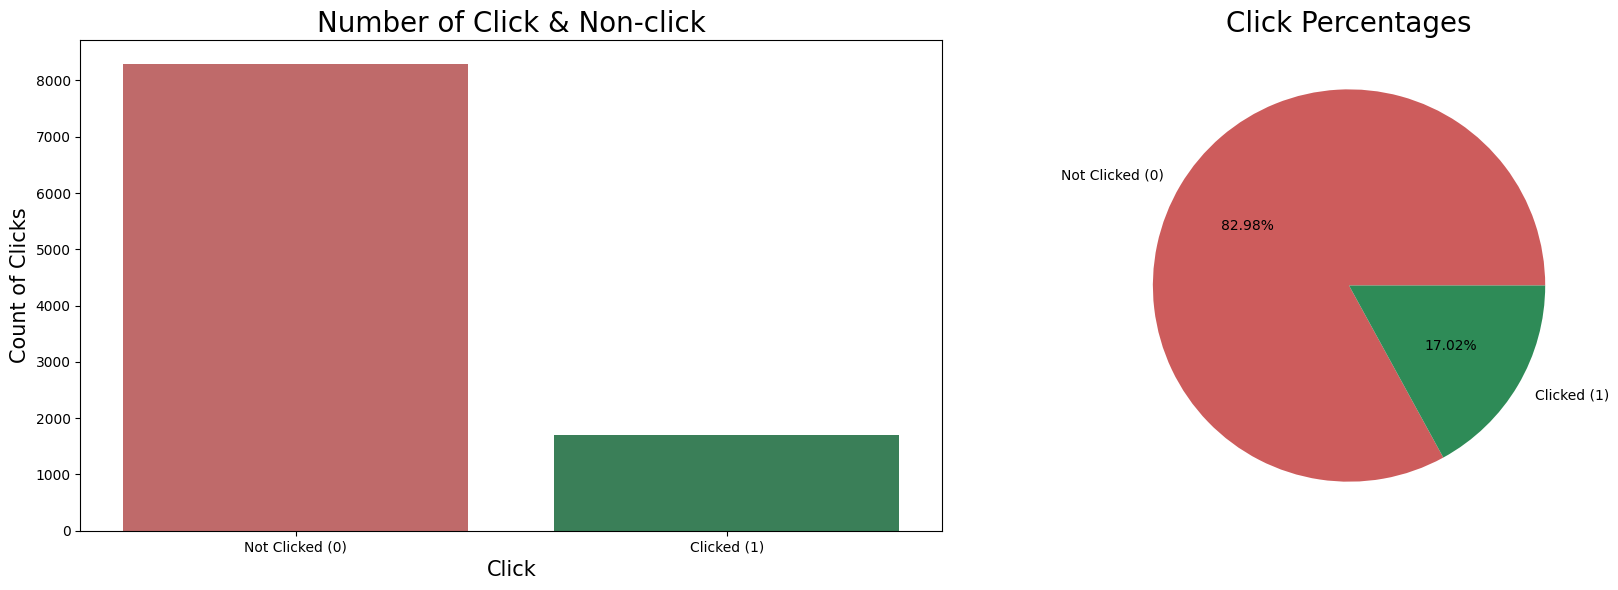

In [33]:
# create plots with target
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
#cols = ['r', 'g']
cols = ["IndianRed", "SeaGreen"]
labels = ['Not Clicked (0)', 'Clicked (1)']

# Plot 1: Countplot
sns.countplot(data=train, x='click', ax=axes[0], palette=cols)
axes[0].set_xlabel('Click', fontsize=15)
axes[0].set_ylabel('Count of Clicks', fontsize=15)
axes[0].set_title('Number of Click & Non-click', fontsize=20)
#axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xticklabels(labels)

# Plot 2: Pie Chart
type_group = train.groupby('click').count()
type_group = type_group.reset_index()

axes[1].pie(type_group["id"], labels=labels, colors=cols, autopct='%1.2f%%')
axes[1].set_title('Click Percentages', fontsize=20)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

The overall click through rate is approx. 17%, and 83% is not clicked.

In [34]:
train.hour.describe()

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_27422/1468264.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.hour.describe()


count                   10000
unique                    240
top       2014-10-28 13:00:00
freq                      123
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

The data includes 10 days of click stream data from 2014–10–21 to 2014–10–30, which means 240 different hours. Our subsample includes value from each unique value.

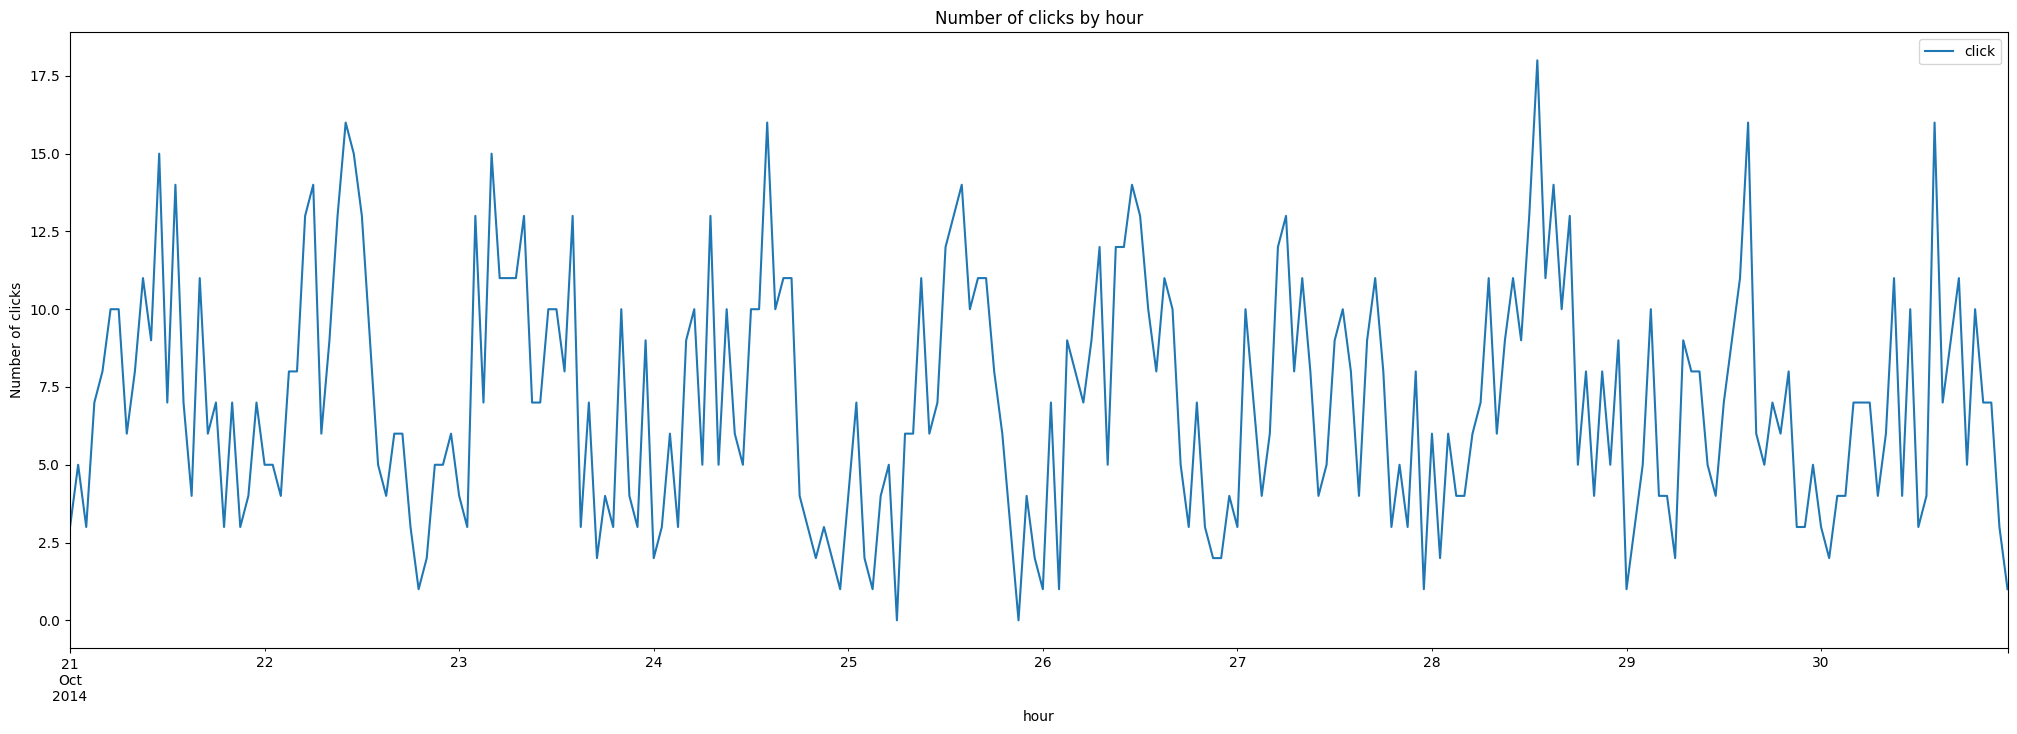

In [39]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(25,8))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour')

Text(0.5, 1.0, 'Hourly Interaction vs. Clicks')

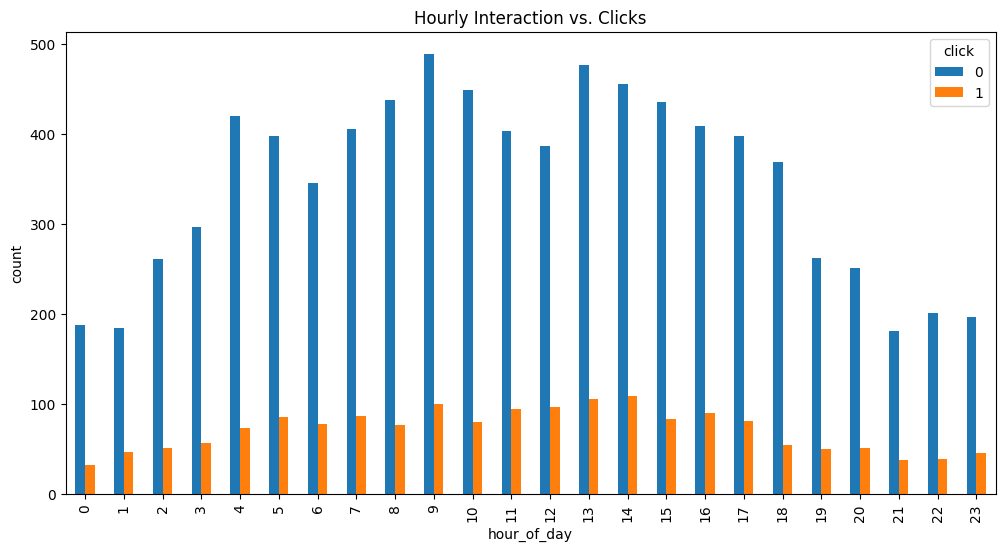

In [79]:
train.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly Interaction vs. Clicks')

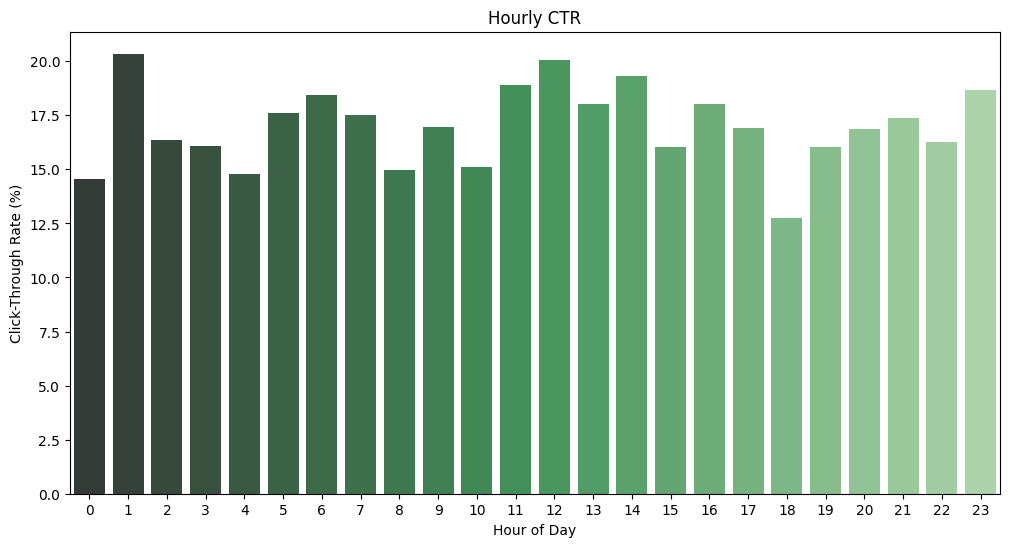

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter rows where 'click' column is 1
df_click = train[train['click'] == 1]

# Calculate interaction counts per hour
df_interaction = train[['hour_of_day', 'click']].groupby(['hour_of_day']).count().reset_index()
df_interaction.rename(columns={'click': 'interaction'}, inplace=True)

# Calculate click counts per hour
df_clicks = df_click[['hour_of_day', 'click']].groupby(['hour_of_day']).count().reset_index()
df_interaction['clicks'] = df_clicks['click']

# Calculate Click-Through Rate (CTR) per hour
df_interaction['CTR'] = (df_interaction['clicks'] / df_interaction['interaction']) * 100

pal = sns.color_palette("Greens_d", len(df_interaction))
rank = df_interaction['CTR'].sort_values().reset_index()['CTR'].argsort().argsort()

# Create a bar plot for Hourly CTR
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='CTR', data=df_interaction, palette=np.array(pal[::-1])[rank])
plt.title('Hourly CTR')
plt.ylabel('Click-Through Rate (%)')
plt.xlabel('Hour of Day')

plt.show()


Text(0.5, 1.0, 'Impressions vs. clicks by day of week')

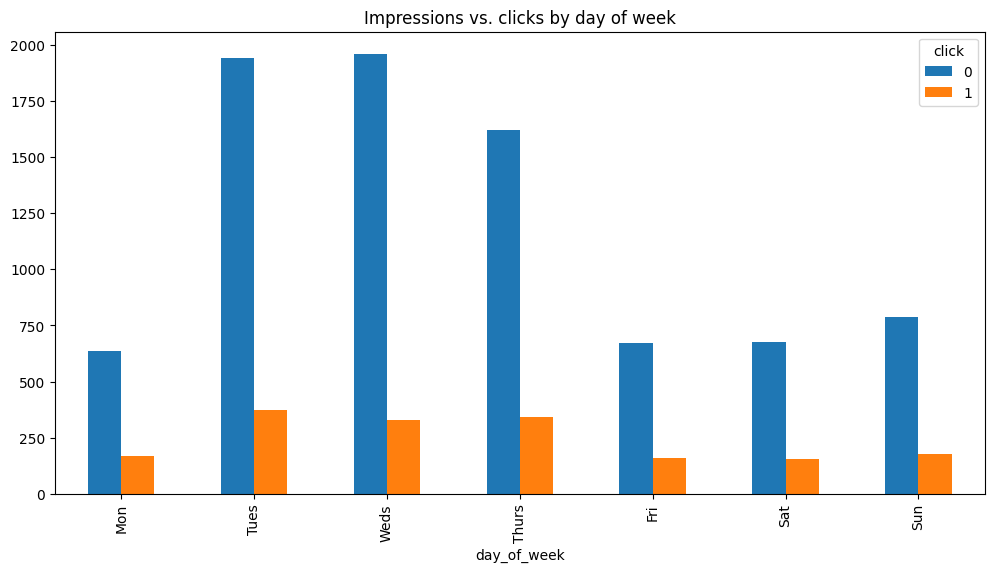

In [88]:
train['day_of_week'] = train['hour'].apply(lambda val: val.day_name())
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

train.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week')

Text(0.5, 1.0, 'Day of week CTR')

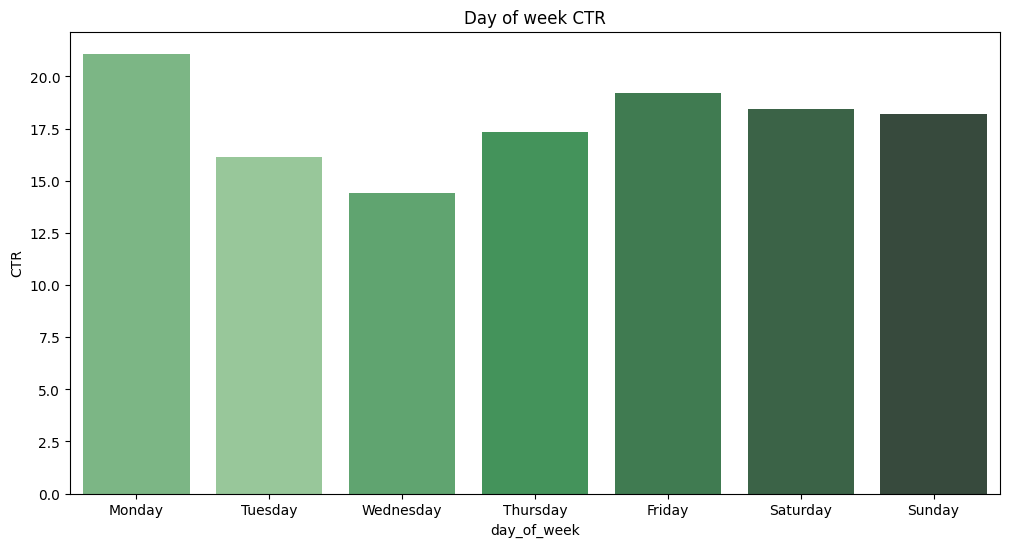

In [136]:
df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'interaction'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['interaction']*100

pal = sns.color_palette("Greens_d", len(df_dayofweek))
rank = df_dayofweek['CTR'].argsort().argsort()

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            palette=np.array(pal[::-1])[rank])
plt.title('Day of week CTR')